In [250]:
from numpy import *;from scipy.constants import pi,m_e,c,kilo,eV; from scipy.special import erfc,erf
from scipy.optimize import curve_fit;from numpy.core.records import fromarrays
from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
import pickle
from scipy.signal import fftconvolve


def resp(t,l=1,s=1,expo=1.):
    return np.exp((s/l)**2./2.+(t.astype(float)**expo)/l -1)*erfc((s**2. + l*(t-l))/(l*s*2.**0.5))

def trig_thresh(t,l=1,s=1,expo=1.):
    return 0.5*resp(t,l,s,expo) - 0.5*erf((l-t.astype(float))/(2.**0.5*s))

def f1(t,s):
    return (2*pi*s**2.)*np.exp(-t.astype(float)**2./(2*s**2.))

def f2(t,tau,B1,B2,B3):
    return B1+B2*np.heaviside(-t,1)+B3*np.exp(t.astype(float)/tau)*np.heaviside(-t,1)

def f(t,s,tau,B1,B2,B3):
    '''s=gauss sigma, tau = exp time constant, B1= constant offset, B2= stepfunction size, B3 = exp rise constant'''
    return fftconvolve(f1(t,s),f2(t,tau,B1,B2,B3),mode='full')
    
    

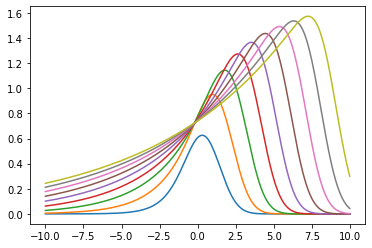

In [2]:
t=arange(-10,10.01,0.01)
span=arange(1,10,1,dtype=float)
for l in span:
    plot(t,resp(t,l=l))

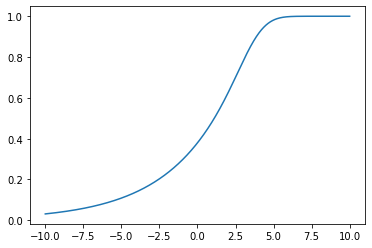

In [154]:
t=arange(-10,10.01,0.01)
plot(t,0.5+trig_thresh(t,l=4,s=1,expo=1))

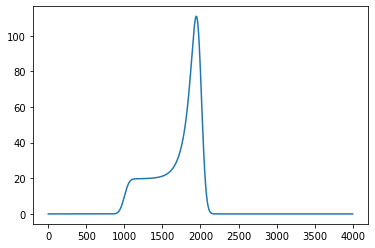

In [3]:
plot(f(t,0.5,1,0,0.1,1))

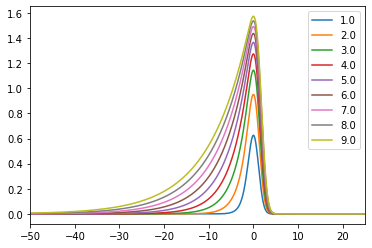

In [4]:
t=arange(-100,100.01,0.01)
span=arange(1,10,1,dtype=float)
for l in span[0:10]:
    plot(t-t[np.argmax(resp(t,l=l))],resp(t,l=l),label=str(l))
xlim(-50,25)
legend()

In [11]:
path='/home/noah/Desktop/large_analysis/zeck_simulation/snbpdip/'
gen_data=load('113Sni.npy').view(np.recarray)
# sim_data=fr.simulation(path+'113Sn.txt').view(np.recarray)

In [20]:
path='/home/noah/Desktop/large_analysis/zeck_simulation/snbpdip'
# np.save(path+'113Sni',gen_data)
# np.save(path+'113Sn.txt',sim_data)

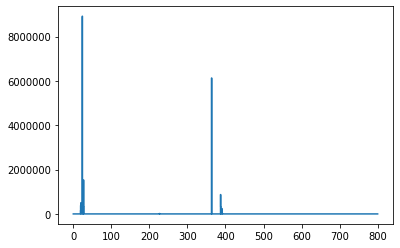

In [12]:
nbins,rang=2000,[0,800]
i_hist,bins=np.histogram(gen_data.energy,bins=nbins,range=rang)
bins=pd.cbins(bins)

plot(bins,i_hist,ds='steps')

## Smearing pars via Sn

(300, 400)

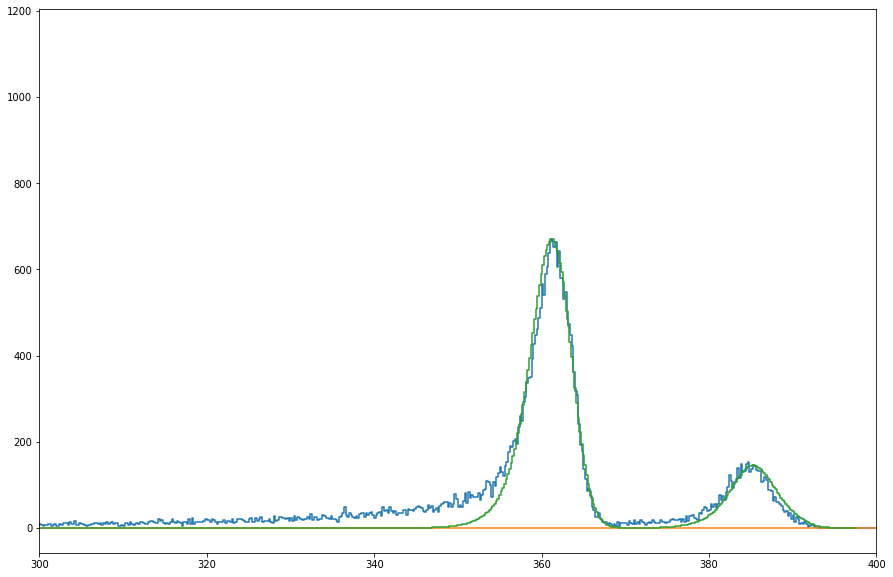

In [142]:
bdch=6
bd,ch=divmod(bdch,8)
path='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/calib_src_runs/'
data=np.hstack((pd.precuts(fr.gen_output(path+'Run_131-all.dat')[0]),pd.precuts(fr.gen_output(path+'Run_132-all.dat')[0]))).view(recarray)
t=(data.board==0)*(data.channel == 6)
data=data[t]
data.energy=pd.vec_calibrate(data.energy,bd,ch)
path='/home/noah/Desktop/large_analysis/zeck_simulation/snbpdip/'
gen_data=load('113Sni.npy').view(np.recarray)

fs=25
l=2
s=2
d_hist=histogram(data.energy,bins=nbins,range=rang)[0]
dist=resp(bins-200,l=l,s=s).astype(float)
dist=dist/np.sum(dist)
vals=bins-bins[np.argmax(dist)]

dE=np.random.choice(vals,p=dist,size=len(gen_data))

re_hist=np.histogram(gen_data.energy+dE,bins=nbins,range=rang)[0]


figure(figsize=(15,10))
plot(bins,d_hist,ds='steps')
plot(bins,i_hist*amax(d_hist)/amax(i_hist[bins>50]),ds='steps')
plot(bins-2.5,re_hist*amax(d_hist)/amax(re_hist[bins>50]),ds='steps')
# plot(bins,1400*resp(bins-359,l=l-6))
xlim(300,400)

## Smearing pars via Ce

(0, 260)

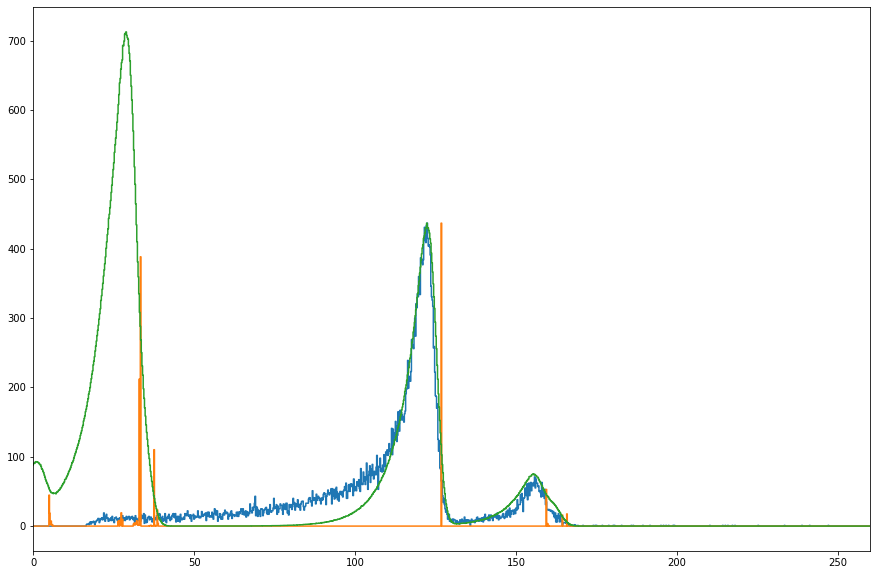

In [344]:
path='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/calib_src_runs/'
data=np.hstack((pd.precuts(fr.gen_output(path+'Run_133-all.dat')[0]),pd.precuts(fr.gen_output(path+'Run_134-all.dat')[0]))).view(recarray)
t=(data.board==0)*(data.channel == 6)
data=data[t]
data.energy=pd.vec_calibrate(data.energy,bd,ch)
path='/home/noah/Desktop/large_analysis/zeck_simulation/cebpdip/'
gen_data=load(path+'139Cei.npy').view(np.recarray)
fs=25
l=7
s=2

d_hist=histogram(data.energy,bins=nbins,range=rang)[0]
dist=resp(bins-200,l=l,s=s).astype(float)
dist=dist/np.sum(dist)
vals=bins-bins[np.argmax(dist)]

dE=np.random.choice(vals,p=dist,size=len(gen_data))

re_hist=np.histogram(gen_data.energy+dE,bins=nbins,range=rang)[0]

i_hist,bins=np.histogram(gen_data.energy,bins=nbins,range=rang)
bins=pd.cbins(bins)

figure(figsize=(15,10))
plot(bins,d_hist,ds='steps')
plot(bins,i_hist*amax(d_hist)/amax(i_hist[bins>50]),ds='steps')
plot(bins-4.5,re_hist*amax(d_hist)/amax(re_hist[bins>50]),ds='steps')
# plot(bins,1400*resp(bins-359,l=l-6))
xlim(0,260)

## Showing smearing of gen spectrum to detector spectrum

In [346]:
path='/home/noah/Desktop/large_analysis/zeck_simulation/45Ca_082019/'
gen_data=load(path+'45Cai_b0.npy').view(np.recarray)
pen_data=pd.sim_comb_single_pixel(load(path+'45Ca_b0.npy')).view(np.recarray)
pen_data.energy+=np.random.normal(loc=0,scale=s,size=np.sum(len(pen_data)))

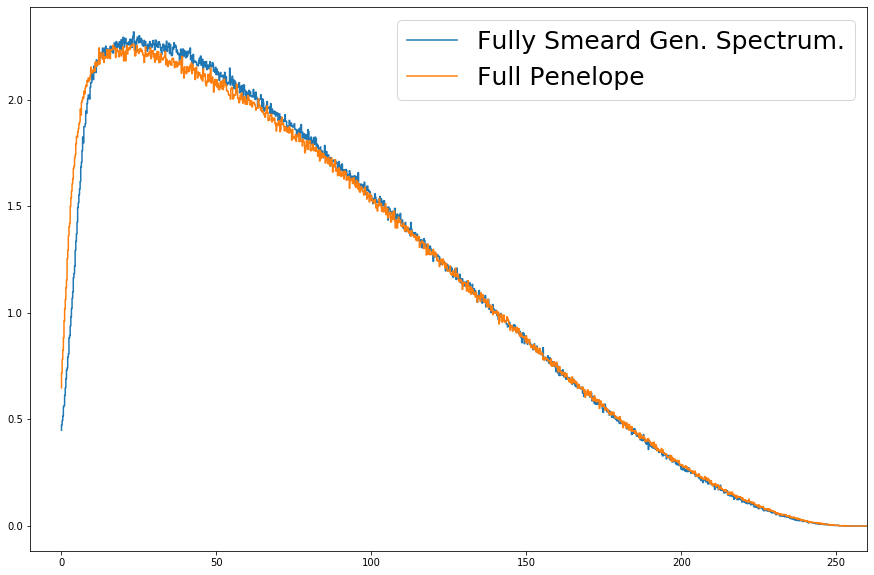

In [418]:

fs=25
l=4.2
s=2

rand_stat=np.random.RandomState(seed=1)

normbin=700

dist=resp(bins-200,l=l,s=s).astype(float)
dist=dist/np.sum(dist)
vals=bins-bins[np.argmax(dist)]

rang=[0,400.1]
dE=rand_stat.choice(vals,p=dist,size=len(gen_data))


re_hist,bins=np.histogram(gen_data.energy,bins=nbins,range=rang)
re_hist=re_hist.astype(float)/re_hist[normbin]
bins=pd.cbins(bins)
figure(figsize=(15,10))
# plot(bins,re_hist,ds='steps',label='Gen. Spectrum')

re_hist,bins=np.histogram(gen_data.energy+dE,bins=nbins,range=rang)
re_hist=re_hist.astype(float)/re_hist[normbin]
bins=pd.cbins(bins)
# plot(bins,re_hist,ds='steps',label='Smeard Gen. Spectrum.')

re_hist,bins=np.histogram(gen_data.energy+dE,bins=nbins,range=rang)
bins=pd.cbins(bins)
re_hist=re_hist.astype(float)/re_hist[normbin]
re_hist=re_hist*(1+erf((bins+15)/30))/2
plot(bins,re_hist,ds='steps',label='Fully Smeard Gen. Spectrum.')

re_hist=np.histogram(pen_data.energy,bins=nbins,range=rang)[0]
re_hist=re_hist.astype(float)/re_hist[normbin]
plot(bins,re_hist,ds='steps',label='Full Penelope')
# re_hist=np.histogram(gen1_data.energy+dE,bins=nbins,range=rang)[0]
# plot(bins,re_hist)
legend(fontsize=fs)
xlim(-10,260)
show()

In [374]:
path='/home/noah/Desktop/large_analysis/zeck_simulation/45Ca_082019/'
gen_data=load(path+'45Cai_b0.npy').view(np.recarray)
pen_data=pd.sim_comb_single_pixel(load(path+'45Ca_b0.npy')).view(np.recarray)
pen_data.energy+=np.random.normal(loc=0,scale=s,size=np.sum(len(pen_data)))

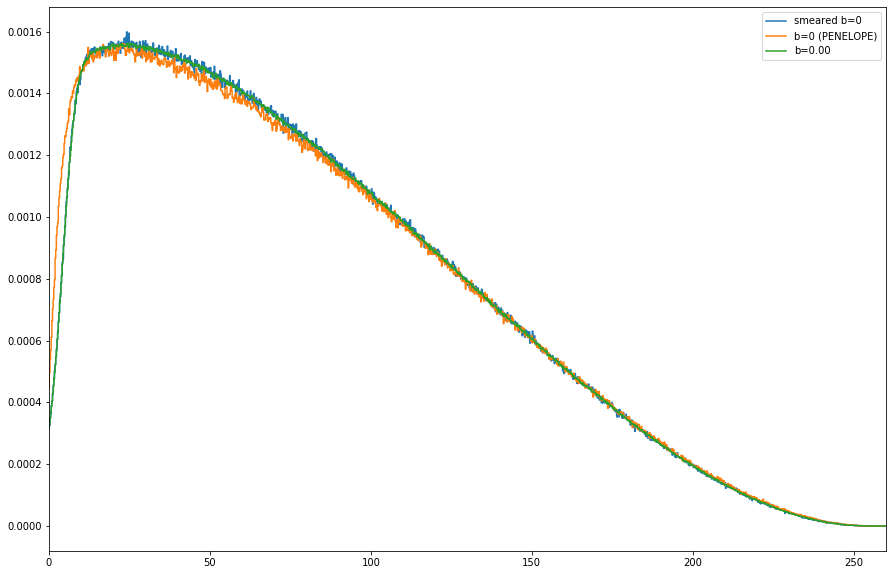

In [403]:
dist=resp(bins-200,l=l,s=s).astype(float)
dist=dist/np.sum(dist)
vals=bins-bins[np.argmax(dist)]
me=m_e*c**2./(kilo*eV)
dE=rand_stat.choice(vals,p=dist,size=len(gen_data))


re_hist,bins=np.histogram(gen_data.energy,bins=nbins,range=rang)
bins=pd.cbins(bins)

b=0
b_hist=re_hist*(1+b/(1.+bins/me))
b_hist=b_hist/np.sum(b_hist)          #Gives me a normalized b=whatever spectrum generated from born spectra

re_hist=np.histogram(gen_data.energy+dE,bins=nbins,range=rang)[0].astype(float)
re_hist=re_hist/re_hist[normbin]
re_hist=re_hist*(1+erf((bins+25)/40))/2
re_hist=re_hist/np.sum(re_hist)


b_energies=np.random.choice(a=bins,p=b_hist,size=int(1e8))
rand_stat=np.random.RandomState(seed=1)
dE=rand_stat.choice(vals,p=dist,size=len(b_energies))
b_energies+=dE
b_hist=np.histogram(b_energies,bins=nbins,range=rang)[0].astype(float)
b_hist=b_hist*(1+erf((bins+25)/40))/2
b_hist=b_hist/np.sum(b_hist)


pe_hist=np.histogram(pen_data.energy,bins=nbins,range=rang)[0]
pe_hist=pe_hist.astype(float)/pe_hist[normbin]
pe_hist=pe_hist/np.sum(pe_hist)


rang=[0,400.1]
dE=rand_stat.choice(vals,p=dist,size=len(gen_data))

figure(figsize=(15,10))
plot(bins,re_hist,ds='steps',label='smeared b=0')
plot(bins,pe_hist,ds='steps',label='b=0 (PENELOPE)')
plot(bins,b_hist,ds='steps',label='b={:0.2f}'.format(b))
xlim(0,260)
legend()
show()

In [404]:
path='/home/noah/Desktop/large_analysis/zeck_simulation/BSG/'
b0=np.load(path+'b0.npy').view(np.recarray)                      # Reading in theoretical spectra for appropriate normalizations
b1=np.load(path+'b1.npy').view(np.recarray)                      # Reading in theoretical spectra for appropriate normalizations
alpha0,alpha1=np.sum(b0.Ne),np.sum(b1.Ne)


path='/home/noah/Desktop/large_analysis/zeck_simulation/ca_small_set/'

b0,b1=load(path+'45Ca_b0.npy'),load(path+'45Ca_b1.npy')               # Reading in 45Ca b=1 b=0 PENELOPE spectra
b0,b1=pd.sim_restructure(b0),pd.sim_restructure(b1)                   # Restructuring the sim data
b0,b1=b0.view(recarray),b1.view(recarray)                             # Making the spectra record arrays (easier)
Fullb0,Fullb1=pd.sim_comb_single_pixel(b0),pd.sim_comb_single_pixel(b1)  #Perfect summed simulated spectra
Fullb0,Fullb1=Fullb0.view(recarray),Fullb1.view(recarray)
Fullb0_hist=histogram(Fullb0.energy,bins=nbins,range=rang)[0]
Fullb1_hist=histogram(Fullb1.energy,bins=nbins,range=rang)[0]
Norm_b0 = 1./np.sum(Fullb0_hist)        # This is used later when taking difference of b=1 and b=0 spectra
Norm_b1 = 1./np.sum(Fullb1_hist)        # This is used later when taking difference of b=1 and b=0 spectra
#b_hist is the histogram to which we're fitting

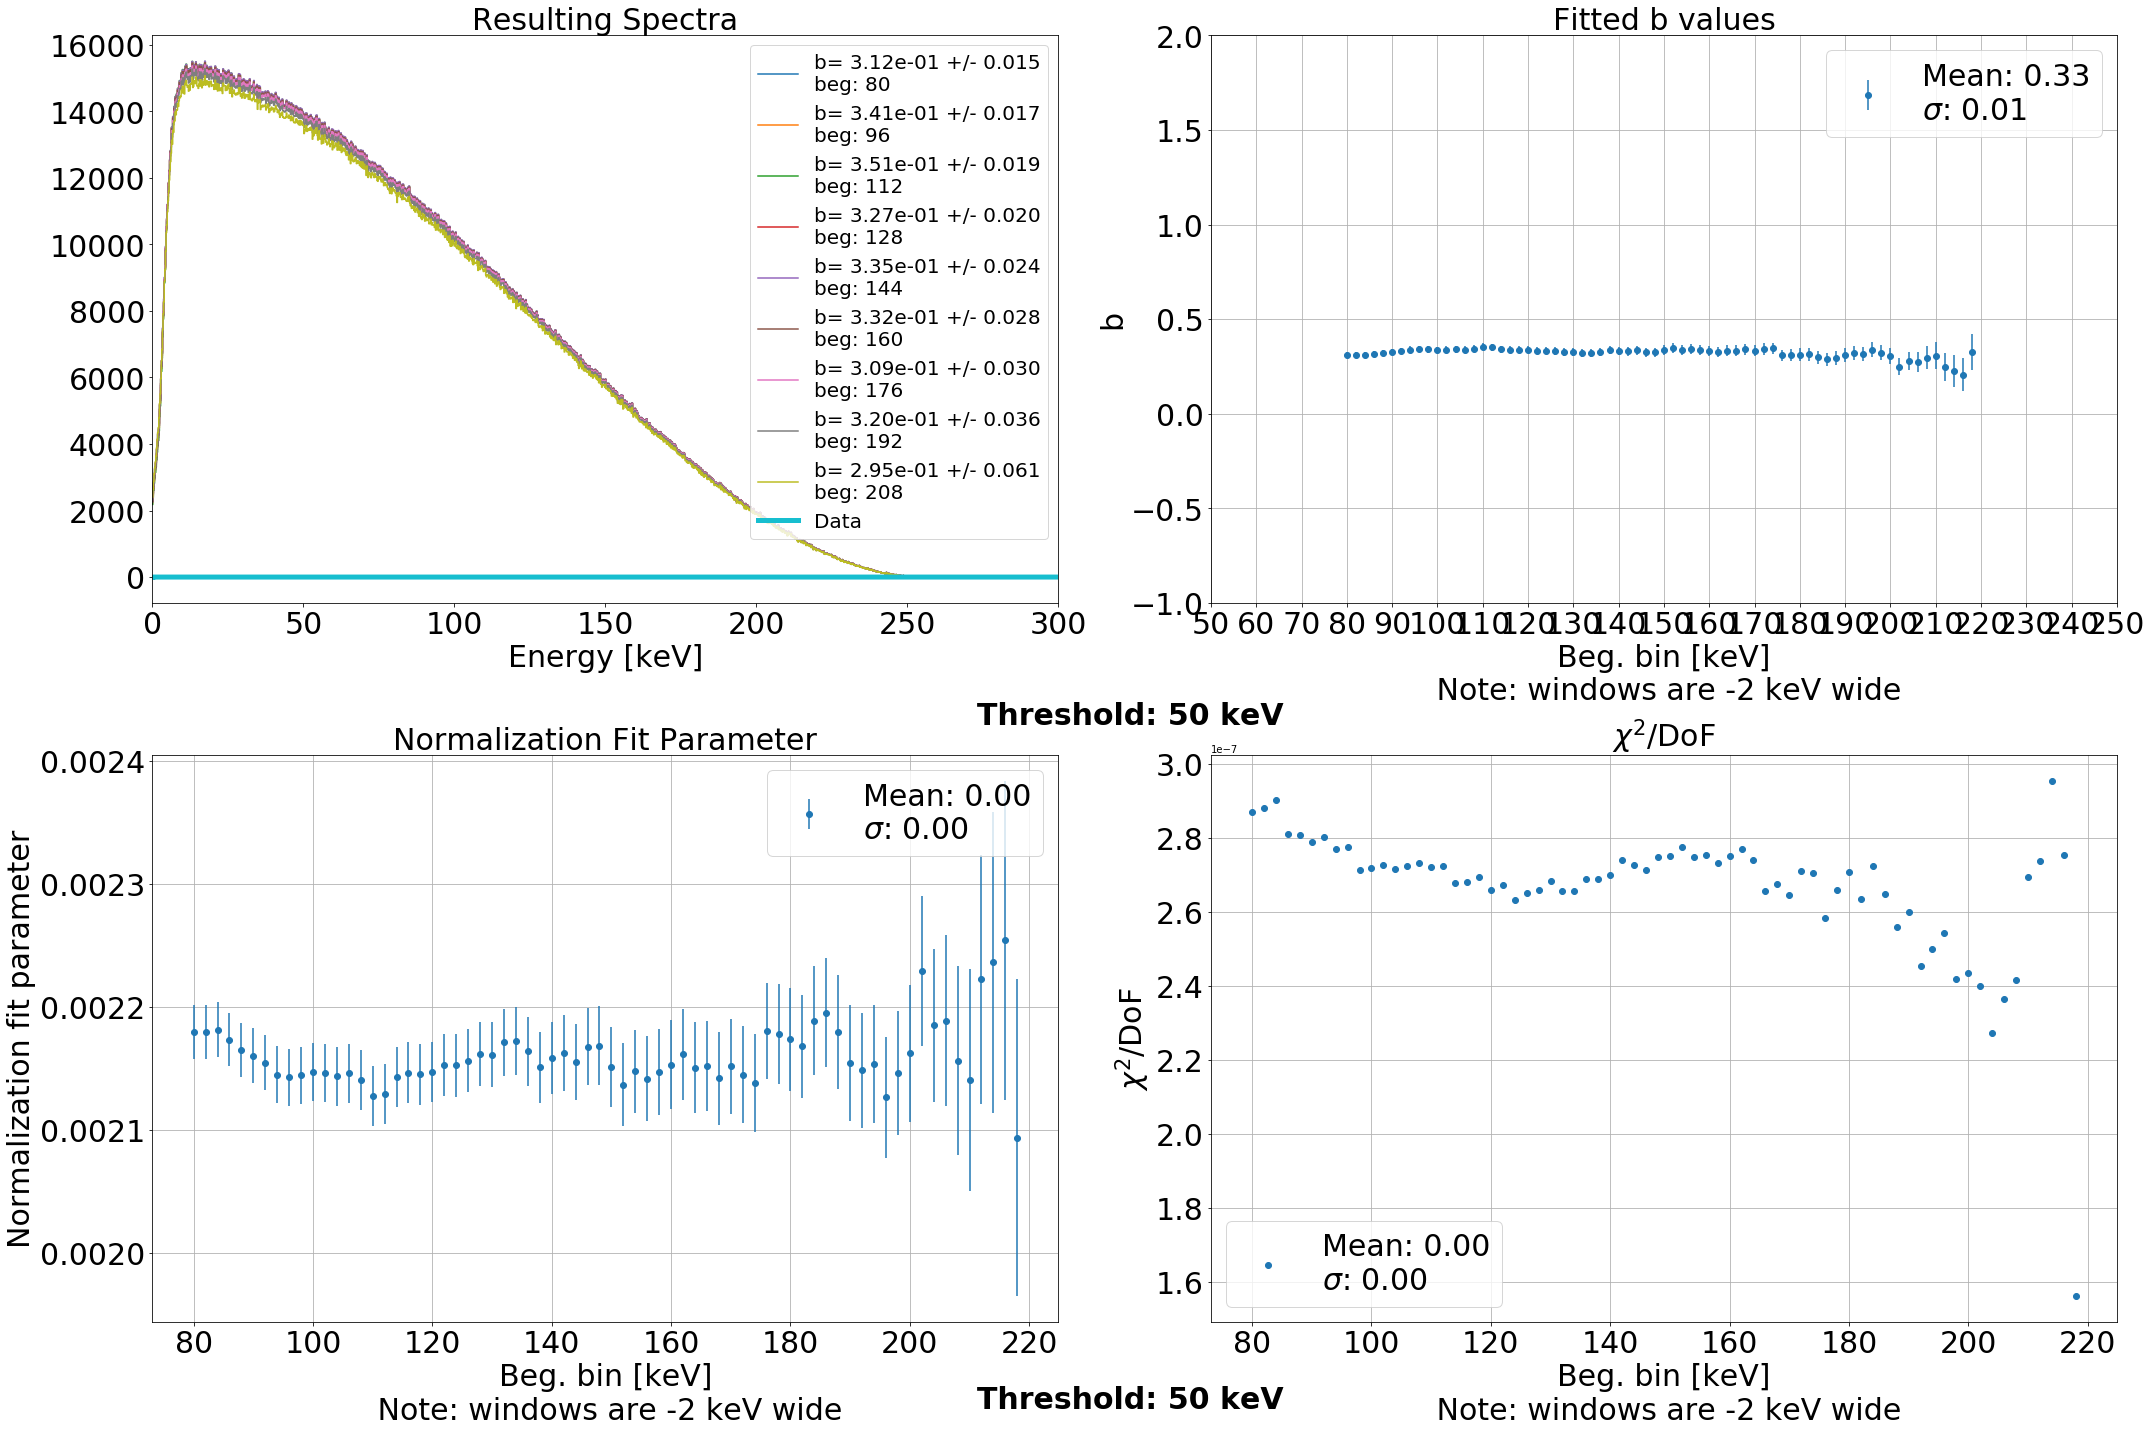

In [420]:


thresh=50
b_vals=ndarray(shape=(0,7))    # b | b error | N | N error | X^2/DoF | begin. fit| end fit
stepsize=0
end=220
steps=arange(80,end,2)
true_bs=[]
true_b_err=[]
beg_bad,end_bad=100,100

# for beg in [steps[0]]:
for beg in steps:
#     end=beg+stepsize                 # 20 keV length == 25 points to fit to
#     if beg_bad<beg<
    if beg > end_bad:
        trutharray = ((bins>beg)*(bins<end))  # Trutharray for fit window
    else:
        trutharray = ((bins>beg)*(bins<beg_bad))+((bins>end_bad)*(bins<end))  # Trutharray for fit window
    rel_uncert_data=sqrt(b_hist[trutharray]);rel_uncert_data[rel_uncert_data==0]=1
    rel_uncert_sim=sqrt(b0_hist[trutharray]);rel_uncert_sim[rel_uncert_sim==0]=1
    rel_uncert_data=1./rel_uncert_data; rel_uncert_sim=1./rel_uncert_sim
    weights=sqrt(rel_uncert_data**2.+rel_uncert_sim**2.)*sqrt(b_hist[trutharray])
#     weights=sqrt(b_hist[trutharray])  # Statistical weights (erros) only


    X=(trutharray,alpha0*Fullb0_hist*Norm_b0,alpha1*Fullb1_hist*Norm_b1)   # Independent values for curve_fit
    
    
    pars,vrs=curve_fit(pd.fierz_fit,X,b_hist[trutharray],\
                      p0=[b_hist[trutharray][0],0],sigma=weights,\
                       ftol=1e-8)
#                       epsfcn=1e-9)

    vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors

    chisq=np.sum((b_hist[trutharray]-pd.fierz_fit(X,*pars))**2./b_hist[trutharray])/(np.sum(trutharray)-len(pars))
    out=np.asarray([pars[1],vrs[1],pars[0],vrs[0],chisq,beg,end])
    b_vals=vstack((b_vals,out))

names='b,b_error,N,N_error,chisq,beg,end'
formats='f8,f8,f8,f8,f8,f8,f8'
b_vals=fromarrays(b_vals.T,names=names,formats=formats) # Converting to recarray for utility
b_vals=b_vals.view(recarray)
del names,formats
np.save('b_vals-T_'+str(thresh),b_vals)
fs=30
fig,ax=subplots(nrows=2,ncols=2,figsize=(30,20))

for i in range(len(b_vals)):
    vals=b_vals[i]
    X=(np.ones(len(bins),dtype=bool),alpha0*b0_hist,alpha1*b1_hist)
#     if i%3==0:
    if vals.beg >0 and i%8==0:
        ax[0,0].plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='b= {:0.2e} +/- {:0.3f}\nbeg: {:0d}'.format(vals.b,vals.b_error,int(vals.beg)))
        
# for i in range(len(b_vals)):
#     vals=b_vals[i]
#     X=(np.ones(len(bins),dtype=bool),b0_hist,b1_hist)
#     if i%3==0:
#     if vals.beg <110 and i%4==0:
#         ax[1,1].plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='b= {:0.2e} +/- {:0.3f}\nbeg: {:0d}'.format(vals.b,vals.b_error,int(vals.beg)))        

trutharray=b_vals.beg<=100
ax[0,0].plot(bins,b_hist,ds='steps',label='Data',lw=5)        
ax[0,0].legend(fontsize=fs-10)
ax[0,0].set_xlim(0,300)
ax[0,0].tick_params(labelsize=fs)
ax[0,0].set_title('Resulting Spectra',fontsize=fs)
ax[0,0].set_xlabel('Energy [keV]',fontsize=fs)
# ax[0,0].set_yscale('log')
ax[0,1].errorbar(b_vals.beg,b_vals.b,b_vals.b_error,fmt='o',\
                 label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.b[trutharray].mean())+': {:0.2f}'.format(b_vals.b[trutharray].std()))
# ax[0,1].errorbar(b_vals.beg,true_bs,true_b_err,fmt='o',\
#                  label='Mean: {:0.2f}\n'r'$\sigma$'.format(true_bs[trutharray].mean())+': {:0.2f}'.format(true_bs[trutharray].std()))
ax[0,1].legend(fontsize=fs)
ax[0,1].tick_params(labelsize=fs)
ax[0,1].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(beg-end),fontsize=fs)
ax[0,1].set_xticks(arange(thresh,300,10))
ax[0,1].grid()
ax[0,1].set_ylabel('b',fontsize=fs)
ax[0,1].set_title('Fitted b values',fontsize=fs)
ax[0,1].set_ylim(-1,2)
ax[0,1].set_xlim(thresh,250)
ax[1,0].errorbar(b_vals.beg,b_vals.N,b_vals.N_error,fmt='o',\
                 label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.N[trutharray].mean())+': {:0.2f}'.format(b_vals.N[trutharray].std()))
ax[1,0].legend(fontsize=fs)
ax[1,0].tick_params(labelsize=fs)
ax[1,0].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(beg-end),fontsize=fs)
ax[1,0].set_ylabel('Normalization fit parameter',fontsize=fs)
ax[1,0].set_title('Normalization Fit Parameter',fontsize=fs)
ax[1,0].grid()
ax[1,1].plot(b_vals.beg,b_vals.chisq,marker='o',ls='None',\
             label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.chisq[trutharray].mean())+': {:0.2f}'.format(b_vals.chisq[trutharray].std()))
ax[1,1].legend(fontsize=fs)
ax[1,1].tick_params(labelsize=fs)
ax[1,1].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(beg-end),fontsize=fs)
ax[1,1].set_ylabel(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].set_title(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].grid()
for i in range(1,4):
    row=int(i/2);col=int(i%2)
#     ax[row,col].set_xlim(150,300)
fig.text(0.525,0.5,text,fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')
text='Threshold: '+str(thresh)+' keV'
fig.text(0.525,0.025,text,fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')
# ax[1].set_ylim(-2,2)
tight_layout()
savefig('single-pixel-T_'+str(thresh))
show()

################################################################################
#                 Testing the smearing via convolutions
################################################################################
path='/home/noah/Desktop/large_analysis/zeck_simulation/45Ca_082019/'
gen_data=load(path+'45Cai_b0.npy').view(np.recarray)
pen_data=pd.sim_comb_single_pixel(load(path+'45Ca_b0.npy')).view(np.recarray)
pen_data.energy+=np.random.normal(loc=0,scale=s,size=np.sum(len(pen_data)))

l=4
s=2

rand_stat=np.random.RandomState(seed=1)
dist=resp(bins-200,l=l,s=s).astype(float)
dist=dist/np.sum(dist)
vals=bins-bins[np.argmax(dist)]
dE=rand_stat.choice(vals,p=dist,size=len(gen_data))
rand_stat.choice(vals,p=dist,size=int(1e8))


b0_hist,bins=np.histogram(pen_data.energy,bins=nbins,range=rang)
bins=pd.cbins(bins)
b0_hist=b0_hist.astype(float)

b=1
me=m_e*c**2./(kilo*eV)

dist=resp(bins-200,l=l,s=s).astype(float)
dist=dist/np.sum(dist)



b1_hist,bins=np.histogram(gen_data.energy,bins=nbins,range=rang)
bins=pd.cbins(bins)
b1_hist=b1_hist.astype(float)
b_hist=fftconvolve(b1_hist,dist)
loc_diff=np.argmax(b_hist)-np.argmax(b1_hist)-20

min_resid=1e20
min_bin=0
for i in np.arange(-50,50,1):
    resid=b_hist[int(loc_diff)+i+100:int(loc_diff+len(b1_hist))+i]-b1_hist[100:]
    resid=np.sum(resid**2.)
    if resid < min_resid:
        min_bin=loc_diff+i
        min_resid=resid
print(min_bin,loc_diff)


b_hist=b_hist[min_bin:min_bin+len(b1_hist)]
b_hist=b_hist*(0.5+0.5*erf((bins+40)/45))


# b_hist=b0_hist*(1+b*1./(1.+bins/me))
# b_hist*=np.amax(b1_hist)/np.amax(b_hist)

figure(figsize=(15,10))
plot(bins,b0_hist,ds='steps',label='b0')
plot(bins,b1_hist,ds='steps',label='b1')
plot(bins,b_hist,ds='steps',label='faked b1')

twinx()
plot(bins,b0_hist-b_hist,c='r',ds='steps')
xlim(0,250)

show()